In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

from train_nn import train_nn, nn_step
from KS_solver import KS_step, ml_step

import torch

from jax_models import *

In [12]:
def f_rand(L):
    nwaves = 5
    a = np.arange(nwaves)+1
    b = np.random.rand(nwaves)
    d = np.random.rand(nwaves)

    xi = np.linspace(0,L,1000)
    fx = xi*0
    for i in range(nwaves):
        fx = fx + b[i]*np.sin(2*a[i]*np.pi*(xi-d[i])/L)
        
    mina = np.min(fx)
    maxa = np.max(fx)

    def f(x):
        fx = x*0
        for i in range(nwaves):
            fx = fx + b[i]*np.sin(2*a[i]*np.pi*(x-d[i])/L)
            
        fx = (fx - mina) / (maxa - mina)   
        return fx

    return f

# Train ML algorithm (autoregressive) for system

In [13]:
# define our KS domain and system
dt = 0.25
s = 128
l=22
M=16
KS = KuramotoSivashinsky(dt=dt, s=s, l=l, M=M)

In [14]:
rollout = 1
stencil = 50
nx = KS.s
model = train_nn(KS, dt, nx, rollout, stencil, f_rand, print_mes=True, nb=5)

0 loss:  0.735251
1 loss:  0.662582
2 loss:  0.575515
3 loss:  0.422865
4 loss:  0.364344
5 loss:  0.357644
6 loss:  0.272364
7 loss:  0.347743
8 loss:  0.293445
9 loss:  0.311807
10 loss:  0.206431
11 loss:  0.216245
12 loss:  0.120552
13 loss:  0.181547
14 loss:  0.181415
15 loss:  0.103799
16 loss:  0.155086
17 loss:  0.093338
18 loss:  0.099914
19 loss:  0.081814
20 loss:  0.100695
21 loss:  0.069777
22 loss:  0.065058
23 loss:  0.058326
24 loss:  0.049722
25 loss:  0.089746
26 loss:  0.051604
27 loss:  0.048254
28 loss:  0.062955
29 loss:  0.040191
30 loss:  0.038914
31 loss:  0.040378
32 loss:  0.041704
33 loss:  0.041163
34 loss:  0.032467
35 loss:  0.029581
36 loss:  0.037769
37 loss:  0.018142
38 loss:  0.040286
39 loss:  0.025306
40 loss:  0.020559
41 loss:  0.016614
42 loss:  0.032284
43 loss:  0.026692
44 loss:  0.021381
45 loss:  0.020713
46 loss:  0.017656
47 loss:  0.011724
48 loss:  0.019687
49 loss:  0.009013
50 loss:  0.018703
51 loss:  0.014404
52 loss:  0.018785
53 

# Test our trained stencil

In [5]:

# inputted as dimensions (time, x)
def nn_step(model, y0, num_steps, stencil, all_steps=True):
    if len(y0.shape)==1:
        y0 = np.expand_dims(y0, 0)
    else:
        y0 = y0.T
    assert(stencil == y0.shape[1])
    y_next = np.zeros((y0.shape[0], stencil+num_steps))
    y_next[:,:stencil] = y0
    y_next = torch.tensor(y_next)
    for i in range(stencil,num_steps+stencil):
        f_t = model(y_next[:,i-stencil:i])
        y_next[:,i] = f_t.squeeze()

    # transpose back to (time,x)
    y_next = y_next.detach().numpy().T
    
    if all_steps:
        return y_next
    else:
        return y_next[-1]

In [6]:
x = np.arange(0,l,l/s)
x_plot = np.linspace(0,l,s+1)
f = f_rand(l)
f0 = f(x)

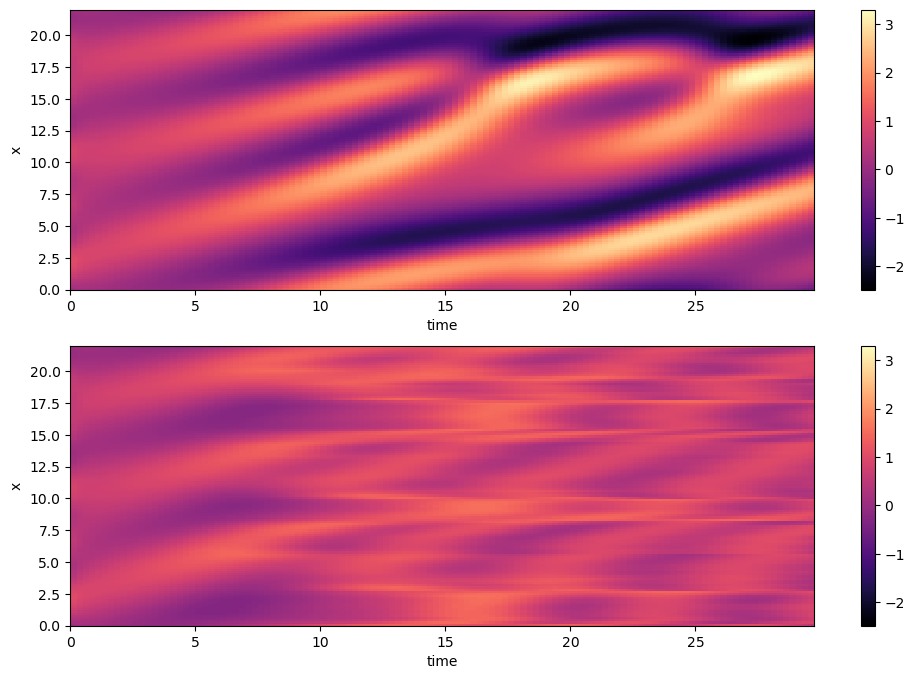

In [7]:
num_steps = 100
t = np.arange(0, KS.dt*(num_steps+stencil-0.1), KS.dt)

data_result = KS_step(KS, num_steps+stencil-1, f0)
y0 = data_result[:stencil]
nn_result = nn_step(model, y0, num_steps, stencil, all_steps=True)

vmax = np.max(data_result)
vmin = np.min(data_result)

fig, ax = plt.subplots(2,1, figsize=(12,8))

cm = ax[0].pcolormesh(t, x_plot, data_result[:-1].T, cmap='magma', vmax=vmax, vmin=vmin)
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
plt.colorbar(cm, ax=ax[0])

ax[1].pcolormesh(t, x_plot, nn_result[:-1].T, cmap='magma', vmax=vmax, vmin=vmin)
ax[1].set_xlabel('time')
ax[1].set_ylabel('x')
plt.colorbar(cm, ax=ax[1])

# Look at individual point
Sicne it is being trained in an autoregressive manner anyway

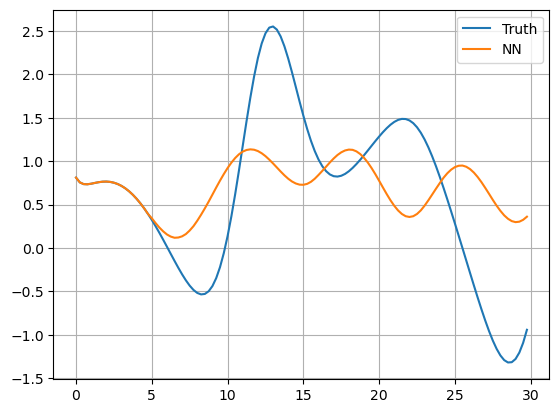

In [10]:
i = 60
data_resulti = data_result[:,i]
ml_resulti = nn_result[:,i]

plt.plot(t, data_resulti, label='Truth')
plt.plot(t, ml_resulti, label='NN')
plt.legend()
plt.grid()

In [28]:
y0.shape

(2, 102)

In [19]:
np.min(nn_result)

-0.10458731409519442